In [1]:
import joblib
import os
import pandas as pd
from pathlib import Path
import signal
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Download model artifact from a previous run

In [12]:
MODEL_FILENAME = "SmoothL1Loss_fixed_Adamax_0.2_testSize_new_StandardScaler_2048_batch_0.008_lr_filtered_nprocs_0.05_dropout_pytorch_v1.12.1.tar"
MODEL_DIR = rf"/home/thes1067/models/blue_waters"
MODEL_PATH = Path(MODEL_DIR, MODEL_FILENAME)

In [3]:
DATASET_DIR = r"/home/thes1067/data/claix_dataset"
DATASET_NAME = "claix_posix_npb_4_16_64_nprocs_Ciao_C_1288.csv"
DATASET_PATH = Path(DATASET_DIR, DATASET_NAME)

In [15]:
MODEL_PATH.is_file()

True

## Load the data

In [4]:
df_claix_posix = pd.read_csv(DATASET_PATH)
df_claix_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_FDSYNCS,...,POSIX_F_VARIANCE_RANK_TIME,POSIX_F_VARIANCE_RANK_BYTES,uid,start_time,end_time,nprocs,jobid,lib_ver,hints,bandwidth
0,32,0,0,440,440,78,0,-1,0,0,...,2.520036,1.084529e+19,38849,2022-07-26 20:10:07,2022-07-26 20:11:18,16,28860382,3.3.1,romio_no_indep_rw=true;cb_nodes=4,1971.700985
1,32,0,0,440,440,78,0,-1,0,0,...,2.567556,1.084529e+19,38849,2022-07-25 23:45:34,2022-07-25 23:46:49,16,28845229,3.3.1,romio_no_indep_rw=true;cb_nodes=4,1952.503983
2,32,0,0,440,440,78,0,-1,0,0,...,2.458673,1.084529e+19,38849,2022-07-26 20:52:45,2022-07-26 20:53:56,16,28860382,3.3.1,romio_no_indep_rw=true;cb_nodes=4,1996.763339
3,32,0,0,440,440,78,0,-1,0,0,...,2.409477,1.084529e+19,38849,2022-07-26 21:41:19,2022-07-26 21:42:29,16,28860382,3.3.1,romio_no_indep_rw=true;cb_nodes=4,2017.040999
4,32,0,0,440,440,78,0,-1,0,0,...,2.466827,1.084529e+19,38849,2022-07-26 18:02:28,2022-07-26 18:03:39,16,28860381,3.3.1,romio_no_indep_rw=true;cb_nodes=4,1992.351330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,8,0,0,440,440,78,0,-1,0,0,...,7.680108,3.470494e+19,42282,2022-06-11 11:06:35,2022-06-11 11:10:11,4,202625,3.3.1,romio_no_indep_rw=true;cb_nodes=4,2026.290698
1284,8,0,0,440,440,78,0,-1,0,0,...,7.748292,3.470494e+19,42282,2022-06-11 10:27:44,2022-06-11 10:31:21,4,19226,3.3.1,romio_no_indep_rw=true;cb_nodes=4,2017.339937
1285,3248,2542,0,107198,9041,78248,397,-43,0,0,...,22.373585,1.648190e+17,36826,2021-08-12 16:44:19,2021-08-12 16:45:59,48,22739983,3.1.8,romio_no_indep_rw=true;cb_nodes=4,687.514696
1286,16112,12718,0,389198,35189,236638,1933,-43,0,0,...,27.839371,4.176090e+16,36826,2021-09-06 14:14:32,2021-09-06 14:15:38,240,23029701,3.1.8,romio_no_indep_rw=true;cb_nodes=4,407.677717


In [5]:
len(df_claix_posix)

1288

### Drop the irrelevant columns

In [23]:
df_claix_posix = df_claix_posix.drop(['uid', 'jobid', 'hints', 'start_time', 'end_time', 'lib_ver'],
                                                               axis=1)

### Drop columns to match the Blue Waters dataset on which the model was trained

In [24]:
df_claix_posix = df_claix_posix.drop(['POSIX_FDSYNCS',
                                        'POSIX_RENAMED_FROM',
                                        'POSIX_F_VARIANCE_RANK_TIME',
                                        'POSIX_F_VARIANCE_RANK_BYTES'],
                                        axis=1)			

In [6]:
df_claix_posix["bandwidth"].describe()

count    1288.000000
mean     1764.640817
std       425.709922
min         0.084217
25%      1923.457805
50%      1984.022055
75%      2007.569354
max      2070.166839
Name: bandwidth, dtype: float64

In [26]:
df_claix_posix["nprocs"].unique()

array([ 16,   4,  64, 162,  48, 144, 240])

<AxesSubplot:title={'center':'Boxplot for bandwidth'}, xlabel='bandwidth'>

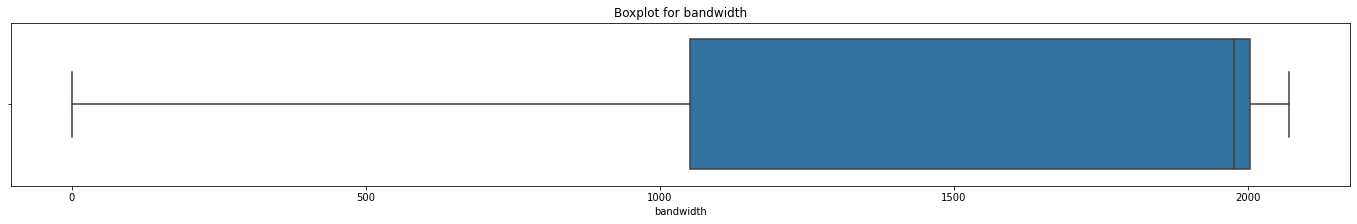

In [27]:
fig = plt.figure(1, figsize=(24, 3))
plt.title("Boxplot for bandwidth")
sns.boxplot(x=df_claix_posix.bandwidth)

<AxesSubplot:xlabel='nprocs', ylabel='Count'>

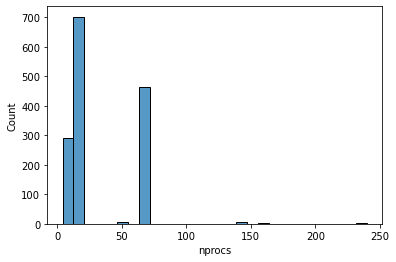

In [28]:
sns.histplot(data=df_claix_posix, x="nprocs")

In [29]:
df_claix_posix["nprocs"].value_counts()

16     702
64     464
4      290
48       6
144      5
162      4
240      3
Name: nprocs, dtype: int64

In [31]:
q25, q75 = np.percentile(df_claix_posix, 25), np.percentile(df_claix_posix, 75)
iqr = q75 - q25

In [32]:
bandwidth_q1 = df_claix_posix.bandwidth.quantile(0.25)
bandwidth_q3 = df_claix_posix.bandwidth.quantile(0.75)
bandwidth_iqr = bandwidth_q3 - bandwidth_q1
bandwidth_iqr

952.2164651654743

In [33]:
filter = (df_claix_posix.bandwidth >= bandwidth_q1 - 1.5 * bandwidth_iqr) & (df_claix_posix.bandwidth <= bandwidth_q3 + 1.5 * bandwidth_iqr)

bandwidth_outliers = df_claix_posix.loc[(filter)==False]
bandwidth_outliers

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_READ_TIME,POSIX_F_WRITE_TIME,POSIX_F_META_TIME,POSIX_TOTAL_TIME,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,nprocs,bandwidth


### Separate bandwidth from input features

In [35]:
df_bandwidth = df_claix_posix.pop("bandwidth")

### Import Pytorch

In [36]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch

import random

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


### Load the pre-trained model

In [ ]:
config = dict(
    epochs=1200,
    learning_rate=0.001,
    weight_decay=1e-5,
    dropout=0.05,
    scaling="StandardScaler",
    outliers=True,
    shuffle=True,
    loss="SmoothL1Loss",
    smooth_l1_loss_beta=1.0,
    optimizer="Adamax",
    learning_rate_scheduler=True,
    pytorch_version=torch.__version__,
    test_size=0.2,
    drop_last=False,
    nprocs_filter=False,
    split_seed=42,
    random_seed=1234,
    stratified_split=False
)

In [39]:
model = nn.Sequential(
    nn.Linear(97, 2048),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(2048, 512),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(128, 1),
).to(device)

In [40]:
model.modules

<bound method Module.modules of Sequential(
  (0): Linear(in_features=97, out_features=2048, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)>

In [41]:
if Path(MODEL_PATH).is_file():
    print("Loading pretrained model...")

    checkpoint = torch.load(MODEL_PATH, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])
    model_epoch = checkpoint['epoch']

    print(f"Current epoch: {model_epoch}")

Loading pretrained model...
Current epoch: 599


### Reset the weights for the output layer for fine-tuning

In [43]:
output_layer = list(model.children())[-1]
output_layer.reset_parameters()

Sequential(
  (0): Linear(in_features=97, out_features=2048, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

# Do the transfer learning

### Fix the seeds


In [52]:
random.seed(config.random_seed)
np.random.seed(config.random_seed)

torch.manual_seed(config.random_seed)
torch.cuda.manual_seed_all(config.random_seed)

# Set PyTorch to use deterministic algorithms if possible
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Results in a crash during the call of F.linear
# torch.use_deterministic_algorithms(True)

## Split the Claix data into the train/test pair

In [53]:
X_train, X_test, y_train, y_test = train_test_split(df_claix_posix,
                                                    df_bandwidth,
                                                    test_size=0.2,
                                                    random_state=config.split_seed,
                                                    stratify=df_claix_posix["nprocs"] if config.stratified_split else None
                                                    )

In [54]:
len(X_test)

295

In [55]:
len(X_train)

1179

### Scale the input features

In [56]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [57]:
tensor_X_train = torch.Tensor(X_train_scaled).to(device)
tensor_y_train = torch.Tensor(y_train.values).view(-1, 1).to(device) #Transform to a 2D array to avoid shape mismatch (gives errors)

training_dataset = TensorDataset(tensor_X_train, tensor_y_train)
# The dataset is so small we can process it whole in one batch
training_dataloader = DataLoader(training_dataset, batch_size=len(training_dataset), shuffle=config.shuffle)

In [58]:
# ### Scale the test set using the scaler fit on the training set
X_test_scaled = scaler.transform(X_test)

In [59]:
tensor_X_test = torch.Tensor(X_test_scaled).to(device)
tensor_y_test = torch.Tensor(y_test.values).view(-1, 1).to(device) #Transform to a 2D array to avoid shape mismatch (gives errors)

test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
# The dataset is so small we can process it whole in one batch
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [60]:
len(training_dataloader)

1

In [61]:
len(test_dataloader)

1

In [62]:
loss_fn = nn.SmoothL1Loss(reduction="sum").to(device)

In [64]:
optimizer = optim.Adamax(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

In [65]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)

In [66]:
model_epoch = 0
model.train()

Sequential(
  (0): Linear(in_features=97, out_features=2048, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [69]:
def train(epoch):
    size = len(training_dataloader)
    for batch, (X, y) in enumerate(training_dataloader):
        y_pred = model(X)
        
        # Divide the summed loss by the number of elements in the current batch to get the average loss
        loss = loss_fn(y, y_pred) / len(X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss = loss.item()

    model.train()

In [70]:
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() 

    # Divide the summed test loss by the number of elements in the whole test dataset to get the average loss
    test_loss /= len(test_dataloader.dataset)

    return test_loss

In [71]:
for epoch in range(model_epoch, config.epochs):
    train(epoch)
    test_loss = test()
    print(f"Epoch {epoch+1} loss: Avg loss: {test_loss:>8f} \n")

    scheduler.step(test_loss)

    model_epoch = epoch

Epoch 1 loss: Avg loss: 548.434746 

Epoch 2 loss: Avg loss: 388.895127 

Epoch 3 loss: Avg loss: 457.528496 

Epoch 4 loss: Avg loss: 480.999576 

Epoch 5 loss: Avg loss: 467.958686 

Epoch 6 loss: Avg loss: 428.088030 

Epoch 7 loss: Avg loss: 402.044544 

Epoch 8 loss: Avg loss: 448.849470 

Epoch 9 loss: Avg loss: 485.633422 

Epoch 10 loss: Avg loss: 499.736547 

Epoch 11 loss: Avg loss: 501.516949 

Epoch 12 loss: Avg loss: 530.002119 

Epoch 13 loss: Avg loss: 592.977966 

Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.
Epoch 14 loss: Avg loss: 653.960593 

Epoch 15 loss: Avg loss: 710.377436 

Epoch 16 loss: Avg loss: 771.381621 

Epoch 17 loss: Avg loss: 852.889619 

Epoch 18 loss: Avg loss: 968.805826 

Epoch 19 loss: Avg loss: 1101.056462 

Epoch 20 loss: Avg loss: 1225.702331 

Epoch 21 loss: Avg loss: 1354.775000 

Epoch 22 loss: Avg loss: 1492.107733 

Epoch 23 loss: Avg loss: 1639.284216 

Epoch 24 loss: Avg loss: 1785.044492 

Epoch 00024: reducing learnin

In [72]:
def build_model_name(config):
    model_name = f"{config.loss}"

    model_name+=f"_{config.test_size}_testSize"

    model_name += f"_{config.scaling}"
    model_name+=f"_{config.learning_rate}_lr"

    if(hasattr(config, "nprocs_filter") and config.nprocs_filter):
        model_name+= f"_{config.nprocs}_nprocs"
    
    model_name+=f"_{config.dropout}_dropout_pytorch_v{config.pytorch_version}"

    return model_name

In [73]:
CLAIX_MODEL_DIR = "/home/thes1067/models/claix"
CLAIX_MODEL_NAME = build_model_name(config)
CLAIX_MODEL_PATH = Path(CLAIX_MODEL_DIR, CLAIX_MODEL_NAME)

In [74]:
torch.save({
    'epoch': model_epoch,
    'model_state_dict': model.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict()
}, CLAIX_MODEL_PATH)